# Detecting Facial Keypoints using Convolutional Neural Networks

Problem statement and data:
https://www.kaggle.com/c/facial-keypoints-detection

Referenced code from Daniel's tutorial:
http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

References:  
Histogram stretching: http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html  
CN architecture: http://cs231n.github.io/neural-networks-2/  
CN architecture: http://neuralnetworksanddeeplearning.com/chap6.html  
EC2 GPU setup: http://markus.com/install-theano-on-aws/

In [7]:
# loading packages
%matplotlib inline

import os
import sys

import numpy as np
from pandas.io.parsers import read_csv
from scipy import fftpack
from sklearn.utils import shuffle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
import theano
import cPickle as pickle

import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas.io.parsers import read_csv
from datetime import datetime

from skimage import data, img_as_float
from skimage import exposure

import warnings
warnings.filterwarnings("ignore")

In [26]:
# load data
# remove data with wrong labels
# referenced data loading code from Daniel

FTRAIN = '/home/ubuntu/data/facial_keypoints_detection/training.csv'
FTEST = '/home/ubuntu/data/facial_keypoints_detection/test.csv'

bad_train_data = [6492,6493,2321,3296,5556,1877,2289,2199,4263,4828,2194,1907,4490,2090,1747]

def load(test=False, cols=None, ignore=bad_train_data, dropna=True, shuffle_data=True):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe
    
    if not test:
        df.drop(ignore) # delete bad rows in training data
    
    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    if dropna:
        df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    y = None
    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        if shuffle_data:
            X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
            
    return X, y

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)
    
    
# Class to display list as HTML Table in Jupyter Notebook
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [9]:
# Load Full data
Full_X, Full_Y = load(ignore=[], dropna=False, shuffle_data=False)

# Load Good data
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

# Load Test data
Test_X, _ = load(test=True)

X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


We realized that there were some bad trainingset data:
- images that were inproperly labeled
- images that have multiple faces

At times, "bad" labels can be good for generalization. However, if the labels are just wrong, it negatively impacts the model. Thus, we decided to remove it all together. 

The plots below show the images and their labels that we decided to remove.

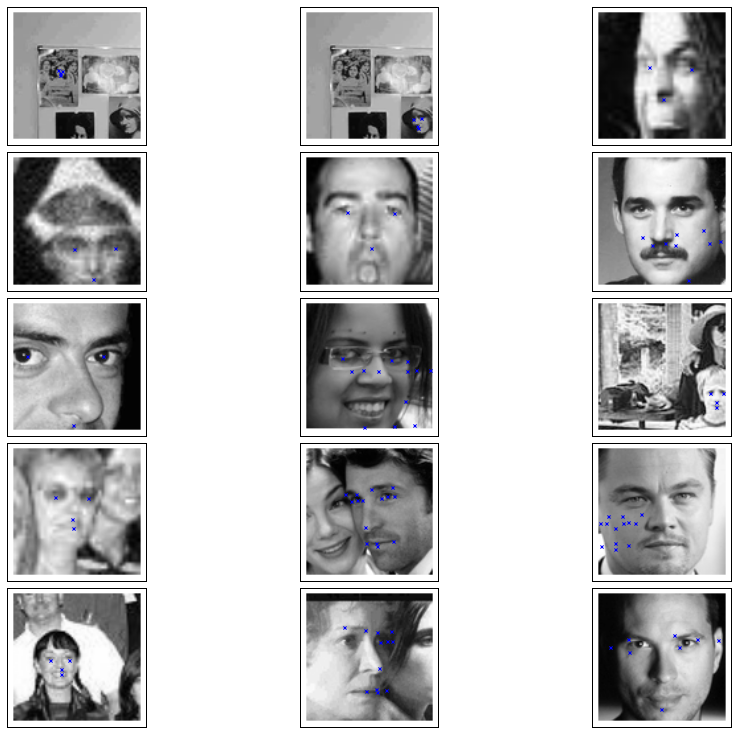

In [10]:
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(bad_train_data)):
    ax = fig.add_subplot(5, 3, i+1, xticks=[], yticks=[])
    plot_sample(Full_X[bad_train_data[i]], Full_Y[bad_train_data[i]], ax)
plt.show()

Since we are planning to use Convolutional Nets, the number of parameters will be significantly beyond 10K, and we only have ~2,000 fully labeled training data, so we decided to use data augmentation, referenced from Daniel's tutorial.

The purpose of data augmentation is to easily increase the training set, in order for the model to be more generalizable. Flipping the images is a simple way to increase the training set data. 

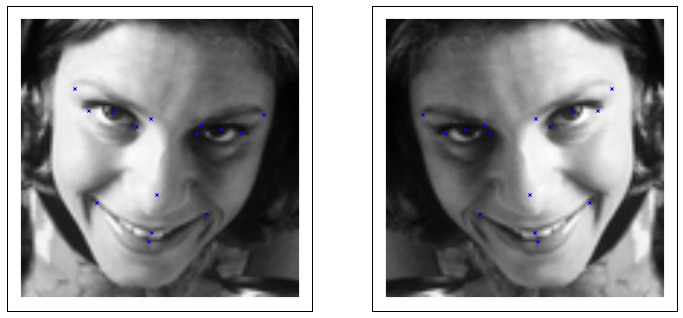

In [11]:
X2d = X.reshape(-1, 1, 96, 96) # reshape image values
X_flipped = X2d[:, :, :, ::-1]  # simple slice to flip all images
y_flipped = np.array(y)
for labels in y_flipped:
    labels[0::2] = -labels[0::2] # flip only the x coordinates
    
# plot two images:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1], y_flipped[1], ax)
plt.show()

class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

Net1:  Single hidden layer NeuralNet (hidden_num_units=100)
First, we compare the performance of single hidden layer NN with variou hidden_layer_number so that we can  choose appropriate number for the following CNN studies.  With the increasing of hidden layer, the training loss will decrease.   However, the validation loss will decrease first and then gradually increase. In addition, with the increasement of hidden number, the computation time for each epoch will increase linearly as well. So in our case, for later CNN, we decided to adopt 300-500 for the number of hidden units.

In [16]:
print X.shape

(2140, 9216)


100
Train, valid errors and computational time of last epcho: 0.0015, 0.0027, 0.0534
200
Train, valid errors and computational time of last epcho: 0.0029, 0.0037, 0.0622
300
Train, valid errors and computational time of last epcho: 0.0087, 0.0091, 0.0733
400
Train, valid errors and computational time of last epcho: 0.0064, 0.0070, 0.0822
500
Train, valid errors and computational time of last epcho: 0.0043, 0.0051, 0.0885
600
Train, valid errors and computational time of last epcho: 0.0122, 0.0122, 0.1038
700
Train, valid errors and computational time of last epcho: 0.0009, 0.0029, 0.1104
800
Train, valid errors and computational time of last epcho: 0.0057, 0.0065, 0.1248
900
Train, valid errors and computational time of last epcho: 0.0132, 0.0132, 0.1355
1000
Train, valid errors and computational time of last epcho: 0.0008, 0.0029, 0.1402


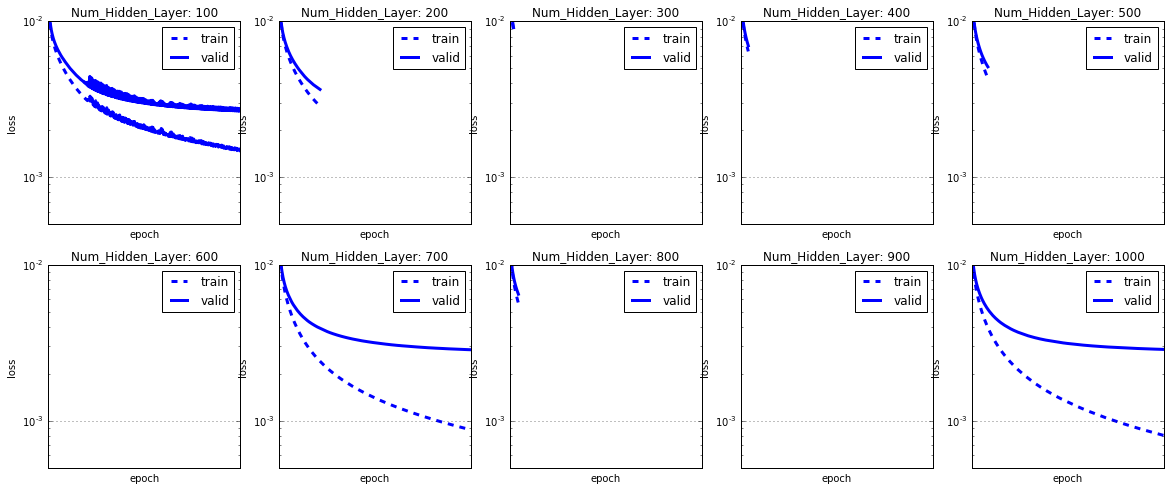

Num_hidden_layer,Train_loss,Validation_loss,Duration_time(s)
100,0.00152,0.00268,0.05336
200,0.00287,0.00366,0.0622
300,0.00873,0.00912,0.0733
400,0.00642,0.00698,0.08216
500,0.00432,0.00511,0.08851
600,0.01216,0.01218,0.10379
700,0.00088,0.00286,0.11044
800,0.00569,0.00649,0.1248
900,0.01318,0.01316,0.13551
1000,0.00081,0.00287,0.14021


In [13]:
# a list of hiddern unit number
hidden_num_units = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# Define a listtable to hold statsitical outcomes of NNs with various hiddern unit numbers 
performance_table_1 = ListTable()
performance_table_1.append(['Num_hidden_layer', 'Train_loss', 'Validation_loss', 'Duration_time(s)'])

fig = plt.figure(figsize=(20,8))

for index,num in enumerate(hidden_num_units):
    net1 = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                             ('hidden', layers.DenseLayer),
                             ('output', layers.DenseLayer),],
                     input_shape=(None, 9216),  # 96x96 input pixels per batch
                     #hidden_num_units=200,  # number of units in hidden layer
                     output_nonlinearity=None,  # output layer uses identity function
                     output_num_units=30,  # 30 target values
                     
                     update=nesterov_momentum, # optimization parameters
                     update_learning_rate=0.01,
                     update_momentum=0.9,
                     
                     regression=True,  # flag to indicate we're dealing with regression problem
                     max_epochs=500,  # we want to train this many epochs
                     verbose=0,)
    net1.hidden_num_units = num
    net1.fit(X, y)
    
    train_loss = np.array([i["train_loss"] for i in net1.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
    print net1.hidden_num_units 
    print "Train, valid errors and computational time of last epoch: %0.4f, %0.4f, %0.4f" %(net1.train_history_[-1]["train_loss"], net1.train_history_[-1]["valid_loss"], net1.train_history_[-1]["dur"])
    performance_table_1.append([net1.hidden_num_units,
                                round(net1.train_history_[-1]["train_loss"],5),
                                round(net1.train_history_[-1]["valid_loss"],5),
                                round(net1.train_history_[-1]["dur"],5)] )
    
    subfig = fig.add_subplot(2, 5, index+1, xticks=[], yticks=[])
    plt.plot(train_loss, linewidth=3, color="blue", linestyle="dashed", label="train")
    plt.plot(valid_loss, linewidth=3, color="blue", linestyle="solid", label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(5*1e-4, 1e-2)
    plt.xlim(0,1000)
    plt.yscale("log")
    subfig.set_title('Num_Hidden_Layer: ' + str(num))

plt.show()
performance_table_1  

Train, valid errors and computational time of last epoch: 0.00145, 0.00300, 0.0874


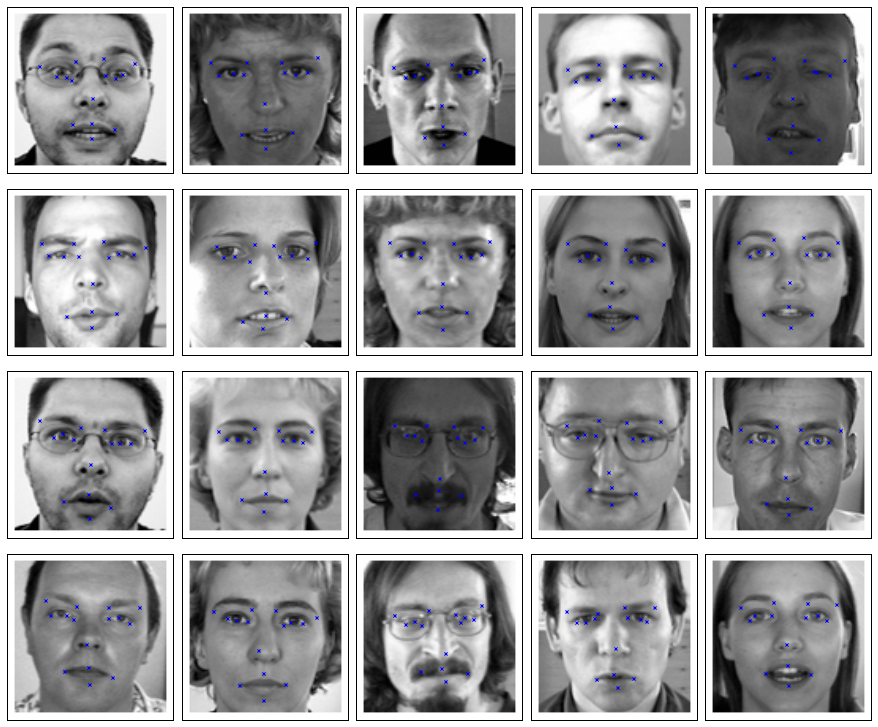

In [17]:
# Build a single layer hidden NN for comparision
net1 = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=500,  # we want to train this many epochs
                 verbose=0,)

net1.fit(X, y)
print "Train, valid errors and computational time of last epoch: %0.5f, %0.5f, %0.4f" %(net1.train_history_[-1]["train_loss"], net1.train_history_[-1]["valid_loss"], net1.train_history_[-1]["dur"])

Test_y_pred = net1.predict(Test_X)

fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Show the predicted labels on test data
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    plot_sample(Test_X[i], Test_y_pred[i], ax)

plt.show()

The following code will perform the following image normalization to improve contrast in images: Histrogram Stretching, Histogram Eqaulization. 

In [18]:
X_stretch = np.empty_like(X)
X_eq = np.empty_like(X)
X_adapteq = np.empty_like(X)

#  Histrogram Stretching
for i in range(X.shape[0]):
    img = X[i,]
    p_lowbound, p_upperbound = np.percentile(img, (1, 99))
    X_stretch[i,] = exposure.rescale_intensity(img, in_range=(p_lowbound,p_upperbound ))

#  Histogram Eqaulization
for i in range(X.shape[0]):
    img = X[i,]
    X_eq[i,] =  exposure.equalize_hist(img,nbins=255)

Fit the new normalization data into the net1

In [20]:
net1_stretch = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=500,  # we want to train this many epochs
                 verbose=0,)

net1_stretch.fit(X_stretch, y)
print "Train, valid errors and computational time of last epoch: %0.5f, %0.5f, %0.4f" %(net1_stretch.train_history_[-1]["train_loss"], net1_stretch.train_history_[-1]["valid_loss"], net1_stretch.train_history_[-1]["dur"])

net1_eq = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=500,  # we want to train this many epochs
                 verbose=0,)
net1_eq.fit(X_eq, y)

print "Train, valid errors and computational time of last epoch: %0.5f, %0.5f, %0.4f" %(net1_eq.train_history_[-1]["train_loss"], net1_eq.train_history_[-1]["valid_loss"], net1_eq.train_history_[-1]["dur"])

Train, valid errors and computational time of last epoch: 0.00145, 0.00291, 0.0879
Train, valid errors and computational time of last epoch: 0.00130, 0.00225, 0.0876


Check whether the normalizaiton transform improve the validation loss.  As shown in the below figure, the Histogram Eqaulization 
 improve the performance of single hidden NN. 

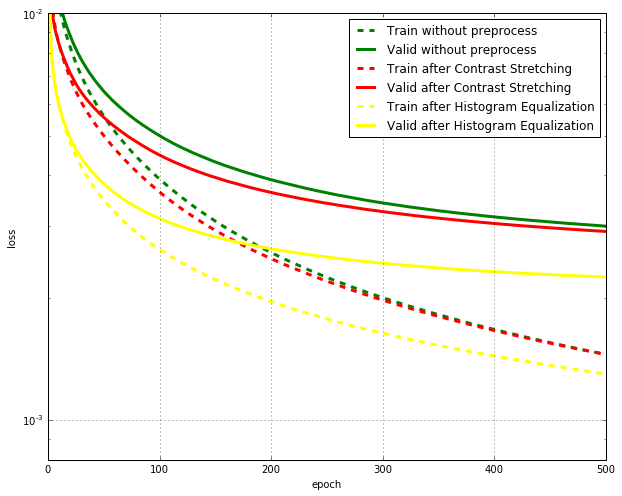

Preprocess,Train_loss,Validation_loss,Duration_time(s)
Without Preprocessing,0.00145,0.003,0.08743
Contrast stretching,0.00145,0.00291,0.08794
Histogram equalization,0.0013,0.00225,0.08765


In [21]:
# Extract training and validation loss for various models
net1_train_loss = np.array([i["train_loss"] for i in net1.train_history_])
net1_valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
net1_str_train_loss = np.array([i["train_loss"] for i in net1_stretch.train_history_])
net1_str_valid_loss = np.array([i["valid_loss"] for i in net1_stretch.train_history_])
net1_eq_train_loss = np.array([i["train_loss"] for i in net1_eq.train_history_])
net1_eq_valid_loss = np.array([i["valid_loss"] for i in net1_eq.train_history_])


# Plot for performance comparision between differnt preprocesses
plt.figure(figsize=(10, 8))
plt.plot(net1_train_loss, linewidth=3,  color="green", linestyle="dashed", label="Train without preprocess")
plt.plot(net1_valid_loss, linewidth=3,  color="green", linestyle="solid", label="Valid without preprocess")
plt.plot(net1_str_train_loss, linewidth=3,  color="red", linestyle="dashed", label="Train after Contrast Stretching")
plt.plot(net1_str_valid_loss, linewidth=3,  color="red", linestyle="solid", label="Valid after Contrast Stretching")
plt.plot(net1_eq_train_loss, linewidth=3,  color="yellow", linestyle="dashed", label="Train after Histogram Equalization")
plt.plot(net1_eq_valid_loss, linewidth=3,  color="yellow", linestyle="solid", label="Valid after Histogram Equalization")

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(8*1e-4, 1e-2)
plt.yscale("log")

plt.show()

# Define a listtable to hold statsitical outcomes of NNs with various preprocessing steps 
performance_table_2 = ListTable()
performance_table_2.append(['Preprocess', 'Train_loss', 'Validation_loss', 'Duration_time(s)'])
performance_table_2.append(['Without Preprocessing',
                            round(net1.train_history_[-1]["train_loss"],5),
                            round(net1.train_history_[-1]["valid_loss"],5),
                            round(net1.train_history_[-1]["dur"],5)] )
performance_table_2.append(['Contrast stretching',
                            round(net1_stretch.train_history_[-1]["train_loss"],5),
                            round(net1_stretch.train_history_[-1]["valid_loss"],5),
                            round(net1_stretch.train_history_[-1]["dur"],5)] )    
performance_table_2.append(['Histogram equalization',
                            round(net1_eq.train_history_[-1]["train_loss"],5),
                            round(net1_eq.train_history_[-1]["valid_loss"],5),
                            round(net1_eq.train_history_[-1]["dur"],5)] )   
performance_table_2  


Net1 is a simple NN with hidden layers.

However, Convolutional Nets are much more suitable for machine learning on images. This is because Convolutional Nets take into consideration the spatial structure of the images.

From here, we will experiment with Convolutional Nets. Starting with Net2. For the purposes of this notebook, we are only going to train Net2 for 10 epochs. As we want to save time for the optimal CN. 

In [22]:
net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128), 
    max_epochs=10,
    verbose=1,
    )

net2.fit(X2d, y)
# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:
with open('net2.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.10257     0.02418    4.24113  8.42s
      2     0.01497     0.01035    1.44686  8.41s
      3     0.00908     0.00797    1.13920  8.42s
      4     0.00794     0.00746    1.06493  8.42s
      5     0.00748     0.00704    1.06202  8.41s
      6     0.00713     0.00670    1.06359  8.41s
      7     0.00683     0.00643    1.06293  8.43s
      8     0.00657     0.00619    1.06265  8.43s
      9     0.00636     0.00597    1.06538  8.42s
     10     0.00616     0.00579    1.06409  8.41s


We experimented with a variety of more complex Convolutional Nets. We ended up on the following construction, which optimized both accuracy, as well as regularization.

We conducted numerous experiments, which we will outline in the presentation. 

In [28]:
# CNet_NPLFXL 
# Differences from Net2, the basic Convolution Net:
# removed all pooling layers
# increased filter size 
# in order to fit into memory, decreased number of filters
# adjustable learning rate & momentum
# dropout

# Histogram equalization for Convolutional Nets
X_eq_new = X_eq.reshape(-1, 1, 96, 96)

CNet_NPLFXL = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        #('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        #('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        #('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=6, conv1_filter_size=(5, 5), #pool1_pool_size=(4, 4),
    dropout1_p=0.1,  # !
    conv2_num_filters=12, conv2_filter_size=(7, 7), #pool2_pool_size=(4, 4),
    dropout2_p=0.2,  # !
    conv3_num_filters=36, conv3_filter_size=(9, 9), #pool3_pool_size=(4, 4),
    dropout3_p=0.3,  # !
    hidden4_num_units=500,
    dropout4_p=0.5,  # !
    hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=1000,
    verbose=1,
    )

import sys
sys.setrecursionlimit(10000)

CNet_NPLFXL.fit(X_eq_new, y)

import cPickle as pickle
with open('CNet_NPLFXL.pickle', 'wb') as f:
    net2_train_loss = np.array([i["train_loss"] for i in net2.train_history_])
    net2_valid_loss = np.array([i["valid_loss"] for i in net2.train_history_])    
    pickle.dump(CNet_NPLFXL, f, -1)

# Neural Network with 109816754 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x96x96
  1  conv1     6x92x92
  2  dropout1  6x92x92
  3  conv2     12x86x86
  4  dropout2  12x86x86
  5  conv3     36x78x78
  6  dropout3  36x78x78
  7  hidden4   500
  8  dropout4  500
  9  hidden5   500
 10  output    30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.06979     0.00568   12.28723  18.88s
      2     0.01493     0.00502    2.97223  18.96s
      3     0.01059     0.00453    2.33908  18.94s
      4     0.00901     0.00451    1.99553  18.97s
      5     0.00809     0.00443    1.82610  18.97s
      6     0.00751     0.00455    1.64952  18.95s
      7     0.00716     0.00445    1.60902  18.95s
      8     0.00685     0.00426    1.60582  18.95s
      9     0.00666     0.00435    1.53182  18.97s
     10     0.00639     0.00429    1.48988  18.93s
     11     0.00632     0.0041

Plot the performance of the final model:

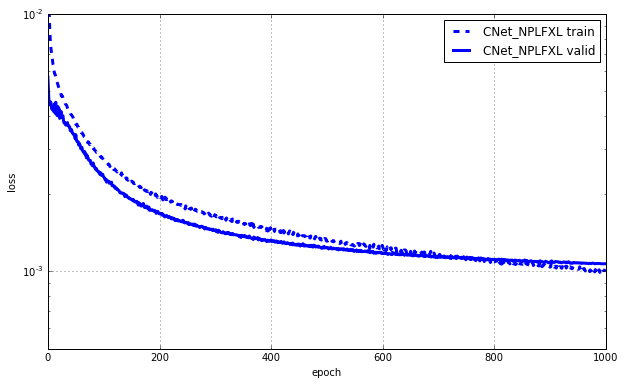

In [30]:
CNet_NPLFXL_train_loss = np.array([i["train_loss"] for i in CNet_NPLFXL.train_history_])
CNet_NPLFXL_valid_loss = np.array([i["valid_loss"] for i in CNet_NPLFXL.train_history_])

plt.figure(figsize=(10, 6))

plt.plot(CNet_NPLFXL_train_loss, linewidth=3,  color="blue", linestyle="dashed", label="CNet_NPLFXL train")
plt.plot(CNet_NPLFXL_valid_loss, linewidth=3,  color="blue", linestyle="solid", label="CNet_NPLFXL valid")

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(5*1e-4, 1e-2)
plt.yscale("log")

plt.show()